Código de Classificação das Contas do Finbra associadas à educação

conta         desc
12      Educação
12.361  Ensino Fundamental
12.363  Ensino Profissional
12.364  Ensino Superior
12.365  Educação Infantil
12.367  Educação Especial
12.999  Demais Subfunções Educação

In [11]:
## Carregamento dos pacotes necessários ao desenvolvimentos do cálculos e dos gráficos
import pandas as pd
import geopandas as gp
import numpy as np
from altair import *
from nupis import *
import matplotlib.pyplot as plt
import pysal as ps
import palettable
%matplotlib inline

**Atenção:** Usou-se o Atlas 2010, mas os dados do Finbra são de 2015. Talvez, seja necessário projetar a população para 2015

In [12]:
## Abertura do arquivo Atlasb que contém dados da população de 2000 a 2010
atlasb = pd.read_csv('C:/Users/alex/python/dissertacao/atlasb.CSV')
atlasb = atlasb.query('ano == 2010')
atlasb = atlasb[atlasb.nome_uf != 'Distrito Federal'] #retirar Distrito Federal (não tem no Desp)

## Abertura arquivos que serão usados nos cálculos e gráficos - Finbra 2015 e Atlas 2000 a 2010
x = pd.read_csv('C:/Users/alex/python/dissertacao/finbra_2015_despesas_por_funcao_liquidadas.csv', 
                sep=';' ,decimal=',', encoding='latin_1', low_memory=False, skiprows=3)

x.columns = x.columns.str.lower()

x.drop('instituição', axis=1, inplace=True)
x = x.join(x.conta.str.split(' - ', expand=True)).drop('conta', axis=1)
x.columns = ['mun', 'uf', 'pop', 'valor', 'cod_conta', 'desc_conta']
x = x.loc[:, ['mun', 'pop', 'cod_conta', 'desc_conta', 'valor']]

#atlas = pd.read_csv('atlas.csv') - não tem a população por faixa etária
cod = atlasb.loc[:, ['nome_mun', 'nome_uf', 'mun', 'uf', 'meso', 'nome_meso','micro',
                     'nome_micro']]

desp = pd.merge(x, cod, on='mun', how='left')

desp = desp.loc[:, ['nome_mun', 'nome_uf','cod_conta', 'desc_conta', 'valor','uf', 'meso', 'nome_meso', 'micro', 'nome_micro', 'mun', 'pop']]

## Transforma as categorias de despesas totais em códigos
desp.cod_conta = desp.cod_conta.str.replace('Despesas \(Exceto Intraorçamentárias\)', '00')
desp.cod_conta = desp.cod_conta.str.replace('Despesas \(Intraorçamentárias\)', '00.1')

In [13]:
# Somatório da população masculina e feminina com idade de 5 a 19 ano-2010

## Somatório da população por faixa etária - Brasil
pop5a14_br = atlasb['homem5a9'].sum() + atlasb['mulh5a9'].sum()+atlasb['homem10a14'].sum()+atlasb['mulh10a14'].sum()

## Somatório da população por faixa etária - MG
desp_mg = atlasb.query('uf == 31')
pop5a14_mg = desp_mg['homem5a9'].sum() + desp_mg['mulh5a9'].sum()+desp_mg['homem10a14'].sum() + desp_mg['mulh10a14'].sum()

## Somatório da população por faixa etária - SSM
desp_ssm = atlasb.query ('meso == 3110')
pop5a14_ssm = desp_ssm['homem5a9'].sum() + desp_ssm['mulh5a9'].sum()+desp_ssm['homem10a14'].sum() + desp_ssm['mulh10a14'].sum()

In [14]:
## Cálculos: Valor da despesa com o Ensino Fundamental, População por área e Valor per capita

## Brasil
valor_br_ef = desp.query('cod_conta == "12.361"').valor.sum()
pop_br = atlasb['pop'].sum()
valor_br_ef_pc = valor_br_ef / pop_br # valor per capita (toda a população)
valor_br_ef_pc_fx = valor_br_ef / pop5a14_br # valor per capita por faixa etária 5 a 14 anos
pop_rel_br = (pop5a14_br / pop_br) * 100

## Estado de MG
valor_mg_ef = desp.query('(cod_conta == "12.361") & (uf == 31)').valor.sum()
pop_mg = atlasb.query('uf == 31')['pop'].sum()
valor_mg_ef_pc = valor_mg_ef / pop_mg # valor per capita (toda a população de MG)
valor_mg_ef_pc_fx = valor_mg_ef / pop5a14_mg # valor per capita por faixa etária 5 a 14 anos
pop_rel_mg = (pop5a14_mg / pop_mg) * 100

## Estado de MG
valor_ssm_ef = desp.query('(cod_conta == "12.361") & (meso == 3110)').valor.sum()
pop_ssm = atlasb.query('meso == 3110')['pop'].sum()
valor_ssm_ef_pc = valor_ssm_ef / pop_ssm # valor per capita (toda a população de MG)
valor_ssm_ef_pc_fx = valor_ssm_ef / pop5a14_ssm # valor per capita por faixa etária 5 a 14 anos
pop_rel_ssm = (pop5a14_ssm / pop_ssm) * 100

**Atenção:** utilizou-se a faixa etária de 5 a 14 anos para se calcular o valor da despesa com EF per capita por faixa etária, no entanto, a faixa etária do EF vai de 6 a 14 anos e não de 5 a 14 anos. Talvez, seja necessário ajustar o Atlas para que se possa ter a faixa etária 6 a 14 anos.

In [15]:
## Geração de tabela com os resultados dos cálculos (Brasil, MG, SSM)
valor_ef = {'Área': ['Brasil','MG','SSM'],
        'Total Despesa EF': [valor_br_ef, valor_mg_ef,valor_ssm_ef],
        'Pop. Total': [pop_br, pop_mg, pop_ssm],
        'Valor Despesa EF pc': [valor_br_ef_pc, valor_mg_ef_pc, valor_ssm_ef_pc],
        'Pop. 5 a 14 anos': [pop5a14_br, pop5a14_mg, pop5a14_ssm],
        'Valor Despesa EF pc / Faixa Etária (5 a 14 anos)': [valor_br_ef_pc_fx, valor_mg_ef_pc_fx, valor_ssm_ef_pc_fx],
        '% Pop. 5 a 14 / Pop. Total Área': [pop_rel_br, pop_rel_mg, pop_rel_ssm]}
valor_ef = pd.DataFrame(valor_ef)
valor_ef = valor_ef.loc[:, ['Área', 'Total Despesa EF','Pop. Total','Valor Despesa EF pc','Pop. 5 a 14 anos','Valor Despesa EF pc / Faixa Etária (5 a 14 anos)','% Pop. 5 a 14 / Pop. Total Área']]
valor_ef.round(2)

,Área,Total Despesa EF,Pop. Total,Valor Despesa EF pc,Pop. 5 a 14 anos,Valor Despesa EF pc / Faixa Etária (5 a 14 anos),% Pop. 5 a 14 / Pop. Total Área
0,Brasil,8.023317e+10,186923547,429.23,31716723,2529.68,16.97
1,MG,6.791807e+09,19471119,348.81,3117155,2178.85,16.01
2,SSM,9.108863e+08,2422871,375.95,372393,2446.03,15.37


In [16]:
## Proporção das Despesas com EF sobre as Despesas Totais com a Educação
desp_br = desp.valor.sum()
desp_mg = desp.query('uf == 31').valor.sum()
desp_ssm = desp.query('meso == 3110').valor.sum()

In [17]:
## Geração de tabela com os resultados dos cálculos (Desp EF / Desp Totais Educação)
desp_eb = {'Área': ['Brasil','MG','SSM'],
        'Total Despesa Educação': [desp_br, desp_mg, desp_ssm],
        'Total Despesa EF': [valor_br_ef, valor_mg_ef, valor_ssm_ef],
        '% Total Despesa EF / Total Despesa Educação': [(valor_br_ef/desp_br)*100, (valor_mg_ef/desp_mg)*100, (valor_ssm_ef/desp_ssm)*100]}
desp_eb = pd.DataFrame(desp_eb)
desp_eb = desp_eb.loc[:, ['Área', 'Total Despesa Educação','Total Despesa EF','% Total Despesa EF / Total Despesa Educação']]
desp_eb.round(2)

,Área,Total Despesa Educação,Total Despesa EF,% Total Despesa EF / Total Despesa Educação
0,Brasil,1.411293e+12,8.023317e+10,5.69
1,MG,1.329964e+11,6.791807e+09,5.11
2,SSM,1.579171e+10,9.108863e+08,5.77


- Verificar como transformar número em notação científica para numeração normal

In [18]:
## Região que mais investe na Educação Fundamental
desp_ef = desp.query('cod_conta == "12.361"')
atlasb = atlasb.query('ano == 2010')
atlasb = atlasb[atlasb.nome_uf != 'Distrito Federal'] #retirar Distrito Federal (não tem no Desp)

## Anos de estudo, média/ano por região brasileira - Dados de 1991, 2000 e 2010
rn  = atlasb.query('uf >= 10 & uf < 20')
rn_pop = rn.homem5a9.sum()+rn.homem10a14.sum()+rn.mulh5a9.sum()+rn.mulh10a14.sum()
#rn_pop = rn_pop.astype(int)

rne  = atlasb.query('uf >= 20 & uf < 30')
rne_pop = rne.homem5a9.sum()+rne.homem10a14.sum()+rne.mulh5a9.sum()+rne.mulh10a14.sum()
#rne_pop = rne_pop.astype(int)

rse  = atlasb.query('uf >= 30 & uf < 40')
rse_pop = rse.homem5a9.sum()+rse.homem10a14.sum()+rse.mulh5a9.sum()+rse.mulh10a14.sum()
#rse = rse_pop.astype(int)

rs  = atlasb.query('uf >= 40 & uf < 50')
rs_pop = rs.homem5a9.sum()+rs.homem10a14.sum()+rs.mulh5a9.sum()+rs.mulh10a14.sum()
#rs_pop = rs_pop.astype(int)

rco  = atlasb.query('uf >= 50 & uf < 60')
rco_pop = rco.homem5a9.sum()+rco.homem10a14.sum()+rco.mulh5a9.sum()+rco.mulh10a14.sum()
#rco_pop = rco_pop.astype(int)

rn1  = desp_ef.query('uf >= 10 & uf < 20')['valor'].sum()
rne1  = desp_ef.query('uf >= 20 & uf < 30')['valor'].sum()
rse1  = desp_ef.query('uf >= 30 & uf < 40')['valor'].sum()
rs1  = desp_ef.query('uf >= 40 & uf < 50')['valor'].sum()
rco1  = desp_ef.query('uf >= 50 & uf < 60')['valor'].sum()

rn = rn1 / rn_pop
rne = rne1 / rne_pop
rse = rse1 / rse_pop
rs = rs1 / rs_pop
rco = rco1 / rco_pop

desp_regiao = {'Região': ['Norte','Nordeste','Sudeste','Sul','Centro-oeste'],
        'Total Despesa EF': [rn1, rne1, rse1,rs1,rco1],
        'Total Pop5a14': [rn_pop,rne_pop,rse_pop,rs_pop,rco_pop],
        'Despesa EF pc': [rn,rne,rse,rs,rco]}
desp_regiao = pd.DataFrame.from_dict(desp_regiao, orient='index')
desp_regiao = pd.DataFrame.transpose(desp_regiao)
desp_regiao.round(2)

,Região,Total Despesa EF,Total Pop5a14,Despesa EF pc
0,Norte,7.08355e+09,3397129,2085.16
1,Nordeste,2.61609e+10,9872781,2649.8
2,Sudeste,2.92371e+10,12267926,2383.22
3,Sul,1.23037e+10,4219573,2915.87
4,Centro-oeste,5.43255e+09,1959314,2772.68


In [9]:
## Estado que mais investe na Educação Fundamental
desp_ef = desp.query('cod_conta == "12.361"')
popest = atlasb[atlasb.nome_uf != 'Distrito Federal'] #retirar Distrito Federal (não tem no Desp)
             
## Atribuir a variável "valor_pc" como uma coluna do Dataframe "desp_ef"
desp_ef = desp_ef.groupby('nome_uf')[['valor']].sum()
poptotal = popest.groupby('nome_uf')[['pop']].sum()
popest = popest.groupby('nome_uf')[['homem5a9','homem10a14','mulh5a9','mulh10a14']].sum()
pop5a14 = popest.homem5a9+popest.homem10a14+popest.mulh5a9+popest.mulh10a14

## População de 5 a 14 anos (por estado) para cálculo de investimento em EF per capita
valor_pc = desp_ef.valor / pop5a14

## Atribuir a variáveis como colunas do Dataframe "desp_ef"
desp_ef = desp_ef.assign(pop5a14 = pop5a14.values)
desp_ef = desp_ef.assign(poptotal = poptotal.values)
desp_ef = desp_ef.assign(valor_pc = valor_pc.values)

desp_ef.sort_values('valor_pc',ascending=False).round(2).reset_index()

,nome_uf,valor,pop5a14,poptotal,valor_pc
0,Mato Grosso do Sul,1.549813e+09,419917,2420664,3690.76
1,Piauí,1.844776e+09,582505,3102750,3166.97
2,Santa Catarina,3.028619e+09,956568,6211295,3166.13
3,Rio de Janeiro,7.472901e+09,2398024,15895914,3116.27
4,Paraíba,2.021626e+09,662780,3744722,3050.22
5,Espírito Santo,1.666267e+09,567201,3492255,2937.70
6,Paraná,4.919264e+09,1677463,10379794,2932.56
7,Sergipe,1.118049e+09,387240,2054721,2887.23
8,Rio Grande do Sul,4.355858e+09,1585542,10618328,2747.24
9,Tocantins,7.499505e+08,275263,1373825,2724.49


In [19]:
## Município que mais investe na Educação Fundamental
desp_ef = desp.query('cod_conta == "12.361"')
desp_ef = pd.merge(desp_ef, atlasb, on= 'mun')

## População de 5 a 14 anos (por estado) para cálculo de investimento em EF per capita
valor_pc = (desp_ef.valor / (desp_ef.homem5a9+desp_ef.homem10a14+desp_ef.mulh5a9+desp_ef.mulh10a14))
pop_5a14 = desp_ef.homem5a9+desp_ef.homem10a14+desp_ef.mulh5a9+desp_ef.mulh10a14

## Atribuir a variável "teste" como uma coluna do Dataframe "desp_ef"
desp_ef = desp_ef.assign(pop_5a14=pop_5a14.values)
desp_ef = desp_ef.assign(valor_pc=valor_pc.values)

desp_ef[['nome_uf_x','mun','nome_mun_x','valor','pop_5a14','valor_pc','homem5a9','homem10a14','mulh5a9','mulh10a14']].sort_values(by='valor_pc', ascending=False).round(2).head(5)

,nome_uf_x,mun,nome_mun_x,valor,pop_5a14,valor_pc,homem5a9,homem10a14,mulh5a9,mulh10a14
1649,Minas Gerais,3161908,São Gonçalo do Rio Abaixo,38566220.53,1750,22037.84,422,480,391,457
3285,Minas Gerais,3166600,Serra da Saudade,2682720.93,129,20796.29,38,32,22,37
4853,Espírito Santo,3204302,Presidente Kennedy,29910644.05,1752,17072.29,392,534,387,439
4864,Rio Grande do Norte,2404507,Guamaré,40349822.15,2466,16362.46,605,645,582,634
4965,Mato Grosso,5106703,Ponte Branca,3976764.19,275,14460.96,64,82,62,67


- Corrigir estados que estão em branco
- No arquivo desp_ef, após o "merge" ficou com muitas variáveis duplicadas. Verificar como retirá-las
- Verificar a divisão das classes. De 0 a 5532 parece-me muito extenso. Pode ser, por exemplo, que 90% dos estados invistam zero no EF e ai aparecem como se investissem investido R$5.5532,04

In [11]:
## Distribuição da Despesa com o Ensino Fundamental por Município - Brasil
br = gp.read_file('shapefiles/BRMUE250GC_SIR.shp')
br.geometry = br.geometry.simplify(0.001)
br.rename(columns={'CD_GEOCMU': 'mun'}, inplace=True)
br['mun'] = br.mun.astype(int)

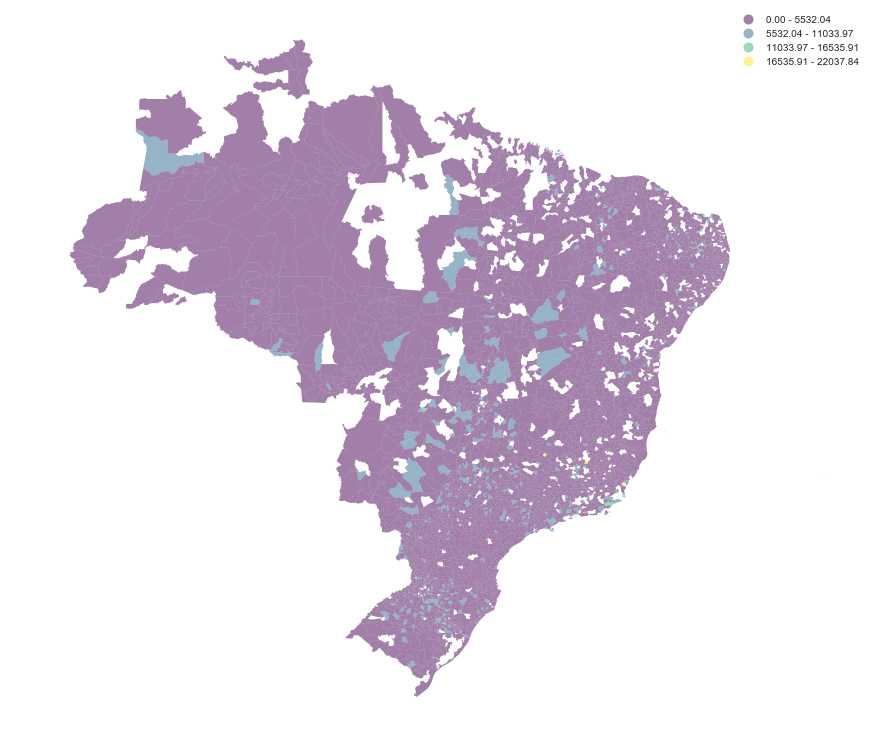

In [13]:
br = pd.merge(br, desp_ef, on='mun')
ax = br.plot(column='valor_pc_y', scheme='equal_interval', k=4, cmap='viridis',
             linewidth=0, figsize=(15,15), legend=True)
ax.set_axis_off();

In [14]:
## Distribuição da Despesa com o Ensino Fundamental por Município - MG
mg = gp.read_file('shapefiles/31MUE250GC_SIR.shp')
mg.geometry = mg.geometry.simplify(0.001)
mg.rename(columns={'CD_GEOCMU': 'mun'}, inplace=True)
mg['mun'] = mg.mun.astype(int)

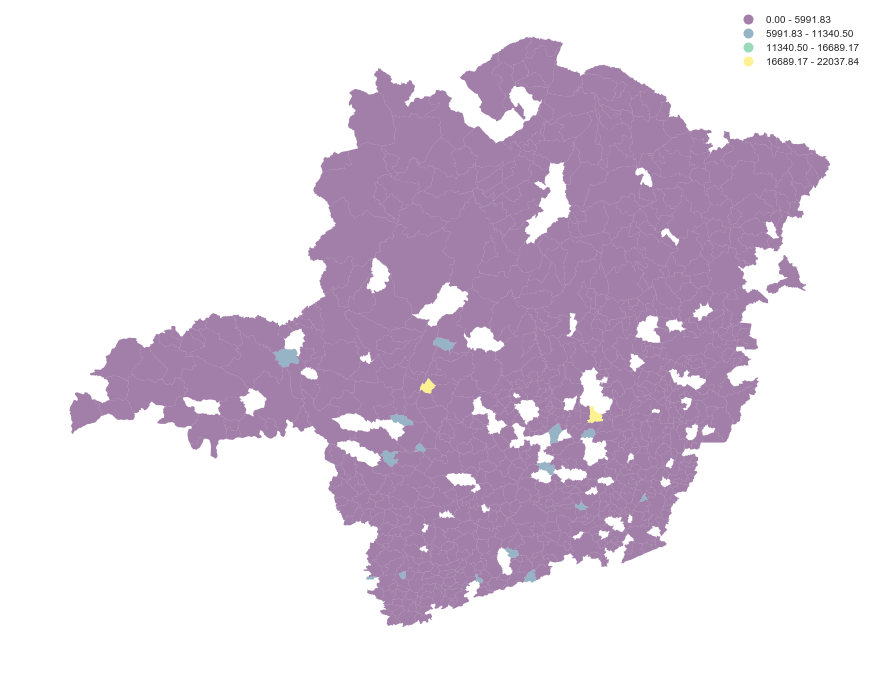

In [16]:
mg = pd.merge(mg, desp_ef, on='mun')
ax = mg.plot(column='valor_pc_y', scheme='equal_interval', k=4, cmap='viridis',
             linewidth=0, figsize=(15,15), legend=True)
ax.set_axis_off();

In [17]:
## Distribuição da Despesa com o Ensino Fundamental por Município - SSM
ssm = gp.read_file('shapefiles/ssm.shp')
ssm.geometry = ssm.geometry.simplify(0.001)
ssm.rename(columns={'CD_GEOCMU': 'mun'}, inplace=True)
ssm['mun'] = ssm.mun.astype(int)

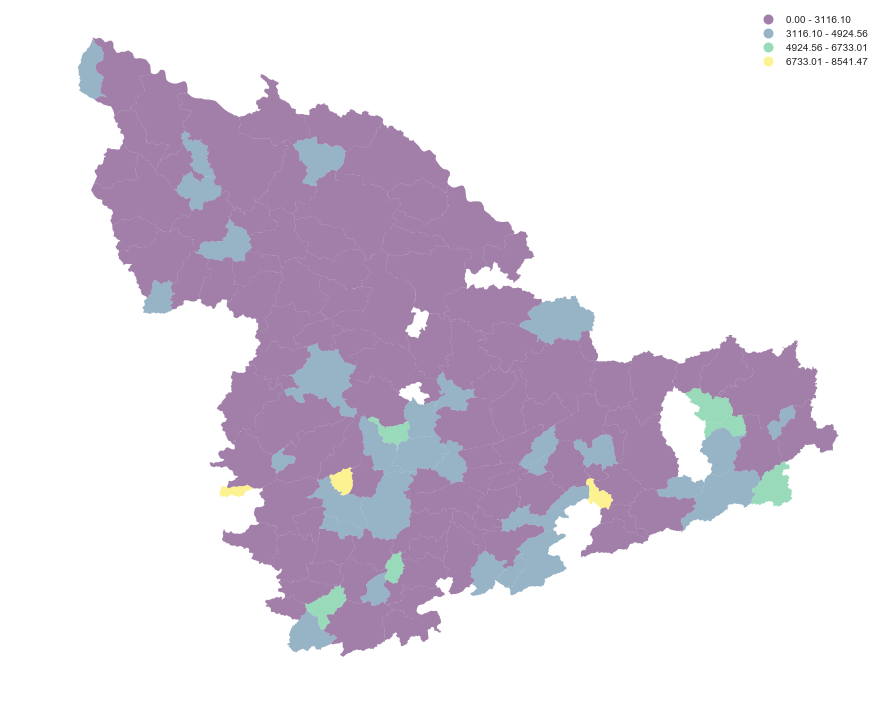

In [19]:
ssm = pd.merge(ssm, desp_ef, on='mun')
ax = ssm.plot(column='valor_pc_y', scheme='equal_interval', k=4, cmap='viridis',
             linewidth=0, figsize=(15,15), legend=True)
ax.set_axis_off();